In [1]:
import os

In [2]:
%pwd

'e:\\GCET\\Machine Learning\\Deep Learning Projects\\text_recognition\\research'

In [3]:
os.chdir('../')

In [4]:
%pwd

'e:\\GCET\\Machine Learning\\Deep Learning Projects\\text_recognition'

In [5]:
from pathlib import Path
dataset_dir='D:/mnt/ramdisk/max/90kDICT32px'

In [6]:
initial_img_path=[]
initial_text_label=[]

with open(os.path.join(dataset_dir,'annotation.txt'), "r", encoding="utf-8") as file:
    lines = file.readlines()
    for i,line in enumerate(lines):
        try:
            path=line.split(" ")[0]
            dir_name, file_name = os.path.split(path)
            label=file_name.split("_")[1]
        except Exception as e:
            print(e," ",i," ",line)

        initial_img_path.append(os.path.join(dataset_dir,path))
        initial_text_label.append(label)

In [7]:
print(len(initial_img_path), len(initial_text_label))

8919273 8919273


In [8]:
vocab=set("".join(map(str,initial_text_label)))

vocab=[char for char in vocab if char.isalnum()]
char_list=sorted(vocab)
print(len(char_list))
print(char_list)

62
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [9]:
#Removing labels and images with non-alphanumeric characters
img_path=[]
text_labels=[]

for i,(path,label) in enumerate(zip(initial_img_path,initial_text_label)):
    if all(char in char_list for char in label):
        img_path.append(path)
        text_labels.append(label)

In [10]:
print(len(img_path), len(text_labels))

8919273 8919273


In [25]:
# Randomly select 30000 images

import numpy as np

size=len(img_path)
random_indices = np.random.choice(size, 3000, replace=False)

In [26]:
img_path=np.array(img_path)
text_labels=np.array(text_labels)

img_path=img_path[random_indices]
text_labels=text_labels[random_indices]

In [27]:
print(len(img_path), len(text_labels))

3000 3000


In [28]:
import cv2

for idx,path in enumerate(img_path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        img_path = np.delete(img_path, idx)
        text_labels = np.delete(text_labels, idx)
    elif len(img.shape) != 2:
        img_path = np.delete(img_path, idx)
        text_labels = np.delete(text_labels, idx)

In [29]:
print(len(img_path), len(text_labels))

3000 3000


In [30]:
max_label_len = max([len(str(text)) for text in initial_text_label])
max_label_len

23

In [31]:
import cv2
import numpy as np

def resize_image(img, canvas_size=(32,128),interpolation=cv2.INTER_LINEAR): ###################################################original
    height,width,channels=img.shape
    target_height32=canvas_size[0]
    target_width128=canvas_size[1]

    if width>height:
        temp_ratio=target_width128/width
        if int(temp_ratio*height)>target_height32:
            ratio=target_height32/height
        else:
            ratio=temp_ratio
    else:
        temp_ratio=target_height32/height
        if int(temp_ratio*width)>target_width128:
            ratio=target_width128/width
        else:
            ratio=temp_ratio
    target_h=int(ratio*height)
    target_w=int(ratio*width)
    #proc=cv2.resize(img,(target_w,target_h),interpolation=interpolation)
    proc=cv2.resize(img,(256,64),interpolation=interpolation) #orignial resize img is (128,32)
    proc=np.expand_dims(proc, axis=-1)

    #resized=np.zeros((target_height32, target_width128, channels),dtype=np.float32)
    #resized[:target_h,:target_w]=proc

    return proc

""" def resize_image(img, canvas_size=(32,128),interpolation=cv2.INTER_LINEAR): 
    proc=cv2.resize(img,(128,32),interpolation=interpolation) #orignial resize img is (128,32)
    proc=np.expand_dims(proc, axis=-1)

    return proc """

' def resize_image(img, canvas_size=(32,128),interpolation=cv2.INTER_LINEAR): \n    proc=cv2.resize(img,(128,32),interpolation=interpolation) #orignial resize img is (128,32)\n    proc=np.expand_dims(proc, axis=-1)\n\n    return proc '

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import cv2

def encode_to_label(txt):
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
    
    return pad_sequences([dig_lst], maxlen=max_label_len, padding='post', value=len(char_list))[0] #maxlen earlier was max_label_len

def get_image(path): ###################################################original
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # # Otsu threshold to detect background vs text
    # _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # # Count white vs black pixels
    # white = np.sum(thresh == 255)
    # black = np.sum(thresh == 0)
    
    # # If background is dark (more black than white), invert
    # if black > white:
    #     img = cv2.bitwise_not(img)

    img = np.expand_dims(img, axis=-1)

    img=resize_image(img)

    blur = cv2.GaussianBlur(img, (1,1), 0)

    _, binary_img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    img = binary_img.astype(np.float32) / 255.0  

    #kernel = np.ones((2, 2), np.uint8)  # You can adjust the kernel size for more thickness

    # Apply dilation to thicken text
    #thickened_text = cv2.erode(img, kernel, iterations=1)

    #thickened_text = np.expand_dims(thickened_text, axis=-1)

    img = np.expand_dims(img, axis=-1)

    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

    return img_tensor

""" def get_image(path): 
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.0  
    img=resize_image(img)
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

    return img_tensor """

""" def get_image(path):
    img = tf.io.read_file(path)

    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)

    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 4. Resize to the desired size
    img = tf.image.resize(img, [32, 128])

    return img """

' def get_image(path):\n    img = tf.io.read_file(path)\n\n    # 2. Decode and convert to grayscale\n    img = tf.io.decode_png(img, channels=1)\n\n    # 3. Convert to float32 in [0, 1] range\n    img = tf.image.convert_image_dtype(img, tf.float32)\n\n    # 4. Resize to the desired size\n    img = tf.image.resize(img, [32, 128])\n\n    return img '

D:/mnt/ramdisk/max/90kDICT32px\./2440/5/490_Serendipity_69575.jpg Serendipity


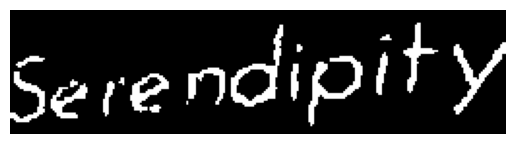

In [33]:
import matplotlib.pyplot as plt

idx=120
temp_img=get_image(img_path[idx])
print(img_path[idx],text_labels[idx])

plt.imshow(temp_img, cmap='gray')  # Use cmap='gray' for grayscale images if needed
plt.axis('off')  # Remove axes for better visualization
plt.show()   

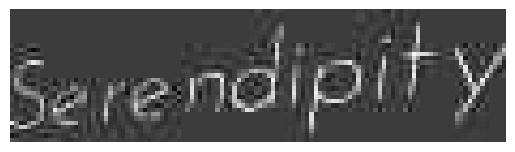

In [34]:
import matplotlib.pyplot as plt

idx=120

plt.imshow(cv2.imread(img_path[idx], cv2.IMREAD_GRAYSCALE), cmap='gray')  # Use cmap='gray' for grayscale images if needed
#plt.imshow(cv2.imread('D:/mnt/ramdisk/max/90kDICT32px\\./181/5/121_Temple_78079.jpg'))  # Use cmap='gray' for grayscale images if needed
plt.axis('off')  # Remove axes for better visualization
plt.show() 

In [37]:
encoded_labels=list(map(encode_to_label,text_labels))

In [38]:
from sklearn.model_selection import train_test_split

train_img_path,test_img_path,train_encoded_labels,test_encoded_labels=train_test_split(img_path,encoded_labels,test_size=0.25, random_state=42)

In [39]:
X_train=list(map(get_image,train_img_path))
y_train=train_encoded_labels

X_test=list(map(get_image,test_img_path))
y_test=test_encoded_labels

In [40]:
batch_size=100

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(lambda img,label: {'image':img,'label':label}, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.map(lambda img,label: {'image':img,'label':label}, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [27]:
X_train[-1].shape

TensorShape([64, 256, 1])

# **Model**

In [44]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Activation, Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [45]:
from itertools import groupby
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []
    
    pred_indcies = np.argmax(predictions, axis=2)
    
    for i in range(pred_indcies.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indcies[i])]
        
        ## remove blanks
        for p in merged_list:
            if p != len(char_list):
                ans += char_list[int(p)]
        
        text_list.append(ans)
        
    return text_list

In [46]:
class CTCLayer(layers.Layer):

    def __init__(self, name=None,**kwargs):

        super().__init__(name=name,**kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

""" class CTCLayer(layers.Layer): ####################### passing logits to CTC loss function instead of softmax output which was incoorect

    def __init__(self, name=None,**kwargs):

        super().__init__(name=name,**kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, logits, softmax_output):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(logits)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, logits, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return softmax_output """

' class CTCLayer(layers.Layer): ####################### passing logits to CTC loss function instead of softmax output which was incoorect\n\n    def __init__(self, name=None,**kwargs):\n\n        super().__init__(name=name,**kwargs)\n        self.loss_fn = keras.backend.ctc_batch_cost\n\n    def call(self, y_true, logits, softmax_output):\n        # Compute the training-time loss value and add it\n        # to the layer using `self.add_loss()`.\n\n        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")\n        input_length = tf.cast(tf.shape(logits)[1], dtype="int64")\n        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")\n\n        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")\n        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")\n\n        loss = self.loss_fn(y_true, logits, input_length, label_length)\n        self.add_loss(loss)\n\n        # At test time, just return the computed predictions\n        r

In [48]:
# model 7
""" def crnn():
    inputs = Input(shape=(64, 256, 1), name="image")

    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    conv_1 = Conv2D(32, (3,3), activation = "selu", padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
    
    conv_2 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_2)
    pool_3 = MaxPool2D(pool_size=(2, 2))(conv_3)

    conv_4 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_3)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
    
    conv_5 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_4)
    
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)
    
    conv_6 = Conv2D(256, (3,3), activation = "selu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
    
    conv_7 = Conv2D(64, (2,2), activation = "selu")(pool_6)
    
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

    softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)

    output = CTCLayer(name="ctc_loss")(labels, softmax_output)

    model = Model(inputs=[inputs, labels], outputs=output)

    return model    """

# model 3
""" def crnn():
    inputs = Input(shape=(32, 128, 1), name="image")

    labels = layers.Input(name="label", shape=(None,), dtype="int32")

    conv_1 = Conv2D(32, (3,3), activation = "selu", padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
    
    conv_2 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_2)
    conv_4 = Conv2D(128, (3,3), activation = "selu", padding='same')(conv_3)

    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
    
    conv_5 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_4)
    
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)
    
    conv_6 = Conv2D(256, (3,3), activation = "selu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
    
    conv_7 = Conv2D(64, (2,2), activation = "selu")(pool_6)
    
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

    softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)

    output = CTCLayer(name="ctc_loss")(labels, softmax_output)

    model = Model(inputs=[inputs, labels], outputs=output)

    return model """

#model 8
""" def crnn():
    inputs = Input(shape=(32, 128, 1), name="image")
    labels = Input(name="label", shape=(None,), dtype="float32")

    conv_1 = Conv2D(16, (3,3), activation="selu", padding='same')(inputs)  # FIXED: filters = 16
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)

    conv_2 = Conv2D(32, (3,3), activation="selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(64, (3,3), activation="selu", padding='same')(pool_2)
    conv_4 = Conv2D(64, (3,3), activation="selu", padding='same')(conv_3)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

    conv_5 = Conv2D(64, (3,3), activation="selu", padding='same')(pool_4)
    batch_norm_5 = BatchNormalization()(conv_5)

    conv_6 = Conv2D(64, (3,3), activation="selu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

    conv_7 = Conv2D(64, (2,2), activation="selu")(pool_6)
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

    softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)

    output = CTCLayer(name="ctc_loss")(labels, softmax_output)

    model = Model(inputs=[inputs, labels], outputs=output)

    return model """

# model 9
def crnn():
    inputs = Input(shape=(64, 256, 1), name="image")
    labels = Input(name="label", shape=(None,), dtype="float32")

    conv_1 = Conv2D(16, (3,3), activation="selu", padding='same')(inputs)  # FIXED: filters = 16
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)

    conv_2 = Conv2D(32, (3,3), activation="selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(64, (3,3), activation="selu", padding='same')(pool_2)
    pool_3 = MaxPool2D(pool_size=(2, 2))(conv_3)

    conv_4 = Conv2D(64, (3,3), activation="selu", padding='same')(pool_3)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

    conv_5 = Conv2D(64, (3,3), activation="selu", padding='same')(pool_4)
    batch_norm_5 = BatchNormalization()(conv_5)

    conv_6 = Conv2D(64, (3,3), activation="selu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

    conv_7 = Conv2D(64, (2,2), activation="selu")(pool_6)
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

    softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)

    output = CTCLayer(name="ctc_loss")(labels, softmax_output)

    model = Model(inputs=[inputs, labels], outputs=output)

    return model

#model 10
""" def crnn():
    inputs = Input(shape=(64, 256, 1), name="image")
    labels = Input(name="label", shape=(None,), dtype="float32")

    conv_1 = Conv2D(16, (3,3), activation="sigmoid", padding='same')(inputs)  # FIXED: filters = 16
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)

    conv_2 = Conv2D(32, (3,3), activation="sigmoid", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(64, (3,3), activation="sigmoid", padding='same')(pool_2)
    pool_3 = MaxPool2D(pool_size=(2, 2))(conv_3)

    conv_4 = Conv2D(64, (3,3), activation="sigmoid", padding='same')(pool_3)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

    conv_5 = Conv2D(64, (3,3), activation="sigmoid", padding='same')(pool_4)
    batch_norm_5 = BatchNormalization()(conv_5)

    conv_6 = Conv2D(64, (3,3), activation="sigmoid", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

    conv_7 = Conv2D(64, (2,2), activation="sigmoid")(pool_6)
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

    softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)

    output = CTCLayer(name="ctc_loss")(labels, softmax_output)

    model = Model(inputs=[inputs, labels], outputs=output)

    return model """

' def crnn():\n    inputs = Input(shape=(64, 256, 1), name="image")\n    labels = Input(name="label", shape=(None,), dtype="float32")\n\n    conv_1 = Conv2D(16, (3,3), activation="sigmoid", padding=\'same\')(inputs)  # FIXED: filters = 16\n    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)\n\n    conv_2 = Conv2D(32, (3,3), activation="sigmoid", padding=\'same\')(pool_1)\n    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)\n\n    conv_3 = Conv2D(64, (3,3), activation="sigmoid", padding=\'same\')(pool_2)\n    pool_3 = MaxPool2D(pool_size=(2, 2))(conv_3)\n\n    conv_4 = Conv2D(64, (3,3), activation="sigmoid", padding=\'same\')(pool_3)\n    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)\n\n    conv_5 = Conv2D(64, (3,3), activation="sigmoid", padding=\'same\')(pool_4)\n    batch_norm_5 = BatchNormalization()(conv_5)\n\n    conv_6 = Conv2D(64, (3,3), activation="sigmoid", padding=\'same\')(batch_norm_5)\n    batch_norm_6 = BatchNormalization()(conv_6)\n    pool_6 = MaxPool2D(pool_size=(2, 1))(batch

In [49]:
model=crnn()

In [50]:
model.compile(optimizer=Adam(learning_rate=0.0007,beta_1=0.9,beta_2=0.999,clipnorm=1))  #Adam(learning_rate=0.0007,beta_1=0.9,beta_2=0.999,clipnorm=1)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 64, 256,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 256,   │        160 │ image[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 128,   │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 128,   │      4,640 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 64,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 64,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 32, 64) │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 32, 64) │     36,928 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 4, 32, 64) │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 4, 32, 64) │     36,928 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 32, 64) │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 4, 32, 64) │     36,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 32, 64) │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 2, 32, 64) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 1, 31, 64) │     16,448 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 31, 64)    │          0 │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 31, 256)   │    197,632 │ lambda_1[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 31, 256)   │    394,240 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 759,103 (2.90 MB)

 Trainable params: 758,847 (2.89 MB)

 Non-trainable params: 256 (1.00 KB)

In [51]:
import math

""" def scheduler(epoch):
  
  if epoch <= 6:
    lrate = 0.0007
  else:
    if epoch%2==1:
      lrate = 0.0007 * (0.1 ** ((epoch-6-1)/2))
    else:
      lrate = 0.00035 * (0.1 ** ((epoch-6-2)/2))
  
  return lrate """

""" def scheduler(epoch):
  
  if epoch <= 5:
    lrate = 0.0007
  elif epoch>=6 and epoch<=13:
      lrate = 0.00035 
  else:
      lrate = 0.0001
  
  return lrate """

def scheduler(epoch):
  
  if epoch <= 4:
    lrate = 0.001
  elif epoch>=5 and epoch<=8:
      lrate = 0.0007
  elif epoch>=9 and epoch<=12:
     lrate = 0.00055
  else:
      lrate = 0.00035
  
  return lrate

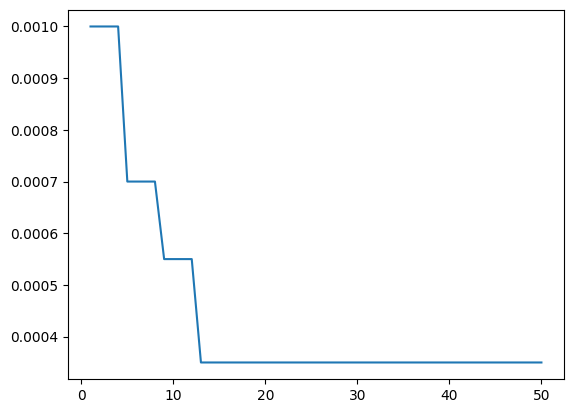

In [52]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 51, 1)]
lrate = [scheduler(i) for i in range(1, 51, 1)]
plt.plot(epochs, lrate)

In [53]:
from comet_ml import Experiment

experiment = Experiment(
    api_key='36u7fQ1u75EQl0qTCvNGxckgo',
    project_name='text-recognition'
)

experiment.log_parameters({"batch_size": batch_size, "epochs": 30, "optimizer":"Adam", "model":"CRNN (model 9)", "activation":"selu","image_size":"(256,64)", "Approach":"Custom", "description":"CRNN with custom approach 7 (model 9), number of channels changed (shuffle=true and yes ReduceLROnPlateau)"})

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorflow, keras, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/shrut2702/text-recognition/afa0d23ed9ed45799b1c30760755320a



In [54]:
class CometLoggingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Log metrics
        if "loss" in logs:
            experiment.log_metric("train_loss", logs["loss"], step=epoch)
        if "val_loss" in logs:
            experiment.log_metric("val_loss", logs["val_loss"], step=epoch)

        # Log learning rate
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        experiment.log_metric("learning_rate", lr, step=epoch)

In [55]:
model_path='artifacts/models/crnn/crnn_best_12.h5'

callbacks = [
    CometLoggingCallback(),
    #tf.keras.callbacks.LearningRateScheduler(scheduler),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.0001),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath="artifacts/models/crnn/crnn_synthdata_custom_7_epoch_{epoch:02d}.h5", save_best_only=False, verbose=1, save_weights_only=False)
    #tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, verbose=1, mode='min', save_weights_only=False)
]

In [56]:
model.fit(train_dataset,validation_data=test_dataset,callbacks=callbacks,epochs=30, shuffle=True)

experiment.end()

Epoch 1/30
140/225 ━━━━━━━━━━━━━━━━━━━━ 5:34 4s/step - loss: 3752.5310

COMET ERROR: Due to connectivity issues, there's an error in processing the heartbeat. The experiment's status updates might be inaccurate until the connection issues are resolved.


141/225 ━━━━━━━━━━━━━━━━━━━━ 10:53 8s/step - loss: 3748.1953

146/225 ━━━━━━━━━━━━━━━━━━━━ 10:20 8s/step - loss: 3727.1509

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 3495.9768
Epoch 1: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_01.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 1630s 7s/step - loss: 3493.8555 - val_loss: 2775.6309 - learning_rate: 7.0000e-04
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 2660.2527
Epoch 2: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_02.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 1027s 5s/step - loss: 2659.7551 - val_loss: 2351.5320 - learning_rate: 7.0000e-04
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 2137.6411
Epoch 3: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_03.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 1051s 5s/step - loss: 2136.8301 - val_loss: 1610.6483 - learning_rate: 7.0000e-04
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 1381.7437
Epoch 4: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_04.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 930s 4s/step - loss: 1381.1976 - val_loss: 1163.7694 - learning_rate: 7.0000e-04
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 981.4210
Epoch 5: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_05.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 889s 4s/step - loss: 981.1973 - val_loss: 927.7768 - learning_rate: 7.0000e-04
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 792.3860
Epoch 6: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_06.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 912s 4s/step - loss: 792.2595 - val_loss: 831.7398 - learning_rate: 7.0000e-04
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 676.7442
Epoch 7: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_07.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 913s 4s/step - loss: 676.6917 - val_loss: 770.7498 - learning_rate: 7.0000e-04
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 608.3903
Epoch 8: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_08.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 890s 4s/step - loss: 608.3454 - val_loss: 716.3930 - learning_rate: 7.0000e-04
Epoch 9/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 546.9578


Epoch 9: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_09.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 912s 4s/step - loss: 546.9443 - val_loss: 744.1953 - learning_rate: 7.0000e-04
Epoch 10/30
  3/225 ━━━━━━━━━━━━━━━━━━━━ 12:59 4s/step - loss: 532.9526

 12/225 ━━━━━━━━━━━━━━━━━━━━ 13:09 4s/step - loss: 520.0724

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 508.9302
Epoch 10: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_10.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 906s 4s/step - loss: 508.8918 - val_loss: 702.4428 - learning_rate: 7.0000e-04
Epoch 11/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 464.9958
Epoch 11: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_11.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 909s 4s/step - loss: 464.9645 - val_loss: 716.1620 - learning_rate: 7.0000e-04
Epoch 12/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 431.7834
Epoch 12: ReduceLROnPlateau reducing learning rate to 6.99999975040555e-05.

Epoch 12: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_12.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 907s 4s/step - loss: 431.7786 - val_loss: 743.8361 - learning_rate: 7.0000e-04
Epoch 13/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 374.7693
Epoch 13: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_13.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 904s 4s/step - loss: 374.6676 - val_loss: 636.8914 - learning_rate: 7.0000e-05
Epoch 14/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 333.5593
Epoch 14: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_14.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 898s 4s/step - loss: 333.5058 - val_loss: 638.1080 - learning_rate: 7.0000e-05
Epoch 15/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 316.0231
Epoch 15: ReduceLROnPlateau reducing learning rate to 6.999999459367246e-06.

Epoch 15: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_15.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 927s 4s/step - loss: 315.9790 - val_loss: 640.9428 - learning_rate: 7.0000e-05
Epoch 16/30
159/225 ━━━━━━━━━━━━━━━━━━━━ 3:52 4s/step - loss: 305.7462

160/225 ━━━━━━━━━━━━━━━━━━━━ 3:49 4s/step - loss: 305.7304

161/225 ━━━━━━━━━━━━━━━━━━━━ 3:45 4s/step - loss: 305.7167

162/225 ━━━━━━━━━━━━━━━━━━━━ 3:42 4s/step - loss: 305.7011

163/225 ━━━━━━━━━━━━━━━━━━━━ 3:38 4s/step - loss: 305.6829

165/225 ━━━━━━━━━━━━━━━━━━━━ 3:31 4s/step - loss: 305.6391

166/225 ━━━━━━━━━━━━━━━━━━━━ 3:28 4s/step - loss: 305.6155

168/225 ━━━━━━━━━━━━━━━━━━━━ 3:21 4s/step - loss: 305.5688

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 302.7311
Epoch 16: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_16.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 909s 4s/step - loss: 302.6755 - val_loss: 622.0205 - learning_rate: 7.0000e-06
Epoch 17/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 297.5706
Epoch 17: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_17.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 920s 4s/step - loss: 297.5222 - val_loss: 622.1116 - learning_rate: 7.0000e-06
Epoch 18/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 295.2016
Epoch 18: ReduceLROnPlateau reducing learning rate to 6.999999641266187e-07.

Epoch 18: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_18.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 895s 4s/step - loss: 295.1556 - val_loss: 622.5302 - learning_rate: 7.0000e-06
Epoch 19/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 293.3634
Epoch 19: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_19.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 922s 4s/step - loss: 293.3154 - val_loss: 622.4073 - learning_rate: 7.0000e-07
Epoch 20/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 292.9389
Epoch 20: ReduceLROnPlateau reducing learning rate to 6.999999868639861e-08.

Epoch 20: saving model to artifacts/models/crnn/crnn_synthdata_custom_7_epoch_20.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 914s 4s/step - loss: 292.8917 - val_loss: 622.3884 - learning_rate: 7.0000e-07
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 16.


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : free_elderberry_5245
COMET INFO:     url                   : https://www.comet.com/shrut2702/text-recognition/afa0d23ed9ed45799b1c30760755320a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     learning_rate [20] : (6.999999868639861e-07, 0.000699999975040555)
COMET INFO:     train_loss [20]    : (282.2577209472656, 3016.51171875)
COMET INFO:     val_loss [20]      : (622.0205078125, 2775.630859375)
COMET INFO:   Parameters:
COMET INFO:     Approach    : Custom
COMET INFO:     activation  : selu
COMET INFO:     batch_size  : 100
COMET INFO:     description : CRNN with custom approach 7 (model 9), number of channels changed (shuffle=true and ye

In [ ]:
pred=model.predict(test_dataset)

75/75 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step


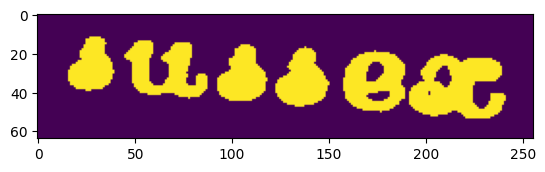

In [ ]:
import matplotlib.pyplot as plt

for batch in test_dataset.take(1):
    images=batch['image']

    #img=(images[22]*255).numpy().astype('uint8')
    img=images[3]
    
    plt.imshow(img)


In [ ]:
ctc_decoder(pred)

['Dieefulness',
 'NICKING',
 'WILLIWAW',
 'sussBG',
 'scholars',
 'EVILLEST',
 'Tracey',
 'TODD',
 'ALACK',
 'PAUPERS',
 'RECOLONIEATION',
 'Staunchness',
 'Recurrences',
 'garnishes',
 'Dejecrian',
 'BLAUEN',
 'chagall',
 'outvoting',
 'pismires',
 'ready',
 'retook',
 'Seraiters',
 'CECCCAN',
 'Ahaaating',
 'perpetrator',
 'LOCKABLE',
 'iviiglies',
 'Oasis',
 'cltroen',
 'swardls',
 'marbleibe',
 'Carl',
 'rehabilitate',
 'Perambulates',
 'SNUGS',
 'CRALAIKAS',
 'MeAtRACK',
 'XARARRY',
 'bondage',
 'Philby',
 'toddhising',
 'mutation',
 'Detoxes',
 'MIRITIAE',
 'FLEMBLE',
 'PIZZAN',
 'Cortwheated',
 'began',
 'Mlap',
 'inaugeral',
 'encapsulation',
 'Def',
 'breeds',
 'Moptaiine',
 'Dictatorial',
 'SUCKERED',
 'LAPELS',
 'CANDIDACIES',
 'Chimp',
 'thief',
 'Myself',
 'uulsecrached',
 'GOSs',
 'SKANST',
 'ONGGAS',
 'Shot',
 'Concepcion',
 'Persevered',
 'Forecourit',
 'aprils',
 'SCARFED',
 'federalist',
 'Pitfalls',
 'hombutgs',
 'CONTOURING',
 'bntiint',
 'mishit',
 'FORMAL',
 'EYEU

In [93]:
test_img_path[3]

np.str_('D:/mnt/ramdisk/max/90kDICT32px\\./124/6/122_sussex_76563.jpg')

# **Prediction**

In [ ]:
""" def crnn_pred():
    inputs = Input(shape=(32, 128, 1), name="image")

    labels = layers.Input(name="label", shape=(None,), dtype="int32")

    conv_1 = Conv2D(32, (3,3), activation = "selu", padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
    
    conv_2 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_2)
    conv_4 = Conv2D(128, (3,3), activation = "selu", padding='same')(conv_3)

    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
    
    conv_5 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_4)
    
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)
    
    conv_6 = Conv2D(256, (3,3), activation = "selu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
    
    conv_7 = Conv2D(64, (2,2), activation = "selu")(pool_6)
    
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

    output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)

    model = Model(inputs=inputs, outputs=output)

    return model """

def crnn_pred():
    inputs = Input(shape=(32, 128, 1), name="image")
    labels = Input(name="label", shape=(None,), dtype="float32")

    conv_1 = Conv2D(16, (3,3), activation="selu", padding='same')(inputs)  # FIXED: filters = 16
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)

    conv_2 = Conv2D(32, (3,3), activation="selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(64, (3,3), activation="selu", padding='same')(pool_2)
    conv_4 = Conv2D(64, (3,3), activation="selu", padding='same')(conv_3)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

    conv_5 = Conv2D(64, (3,3), activation="selu", padding='same')(pool_4)
    batch_norm_5 = BatchNormalization()(conv_5)

    conv_6 = Conv2D(64, (3,3), activation="selu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

    conv_7 = Conv2D(64, (2,2), activation="selu")(pool_6)
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

    output = Dense(62 + 1, activation='softmax', name="dense")(blstm_2)

    model = Model(inputs=inputs, outputs=output)
    return model

def crnn_pred1():
    inputs = Input(shape=(64, 256, 1), name="image")

    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    conv_1 = Conv2D(32, (3,3), activation = "selu", padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
    
    conv_2 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_2)
    pool_3 = MaxPool2D(pool_size=(2, 2))(conv_3)

    conv_4 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_3)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
    
    conv_5 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_4)
    
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)
    
    conv_6 = Conv2D(256, (3,3), activation = "selu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
    
    conv_7 = Conv2D(64, (2,2), activation = "selu")(pool_6)
    
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

    output = Dense(62 + 1, activation='softmax', name="dense")(blstm_2)

    model = Model(inputs=inputs, outputs=output)

    return model

In [ ]:
crnn_pred=crnn_pred()

In [ ]:
model_x = crnn_pred()
model_x.load_weights("artifacts/models/crnn/C_LSTM_best(w&b).hdf5", by_name=True,skip_mismatch=True)

model_y = crnn_pred1()
model_y.load_weights("artifacts/models/crnn/crnn_synthdata_customapproach_3_epoch_09.h5")

In [ ]:
def transfer_weights_by_type(target_model, source_model, layer_class, prefix=""):
    t_layers = [l for l in target_model.layers if isinstance(l, layer_class)]
    s_layers = [l for l in source_model.layers if isinstance(l, layer_class)]

    print(s_layers)

    count = min(len(t_layers), len(s_layers))
    for i in range(count):
        t_layers[i].set_weights(s_layers[i].get_weights())
        print(f"{prefix} Loaded weights for {layer_class.__name__} layer {i}")

In [ ]:
def copy_bidirectional_lstm_weights(dest_model, src_model):
    src_bilstm = [l for l in src_model.layers if isinstance(l, Bidirectional)]
    dest_bilstm = [l for l in dest_model.layers if isinstance(l, Bidirectional)]

    for i in range(min(len(src_bilstm), len(dest_bilstm))):
        try:
            dest_bilstm[i].forward_layer.set_weights(src_bilstm[i].forward_layer.get_weights())
            dest_bilstm[i].backward_layer.set_weights(src_bilstm[i].backward_layer.get_weights())
            print(f"Copied weights for Bidirectional LSTM layer {i}")
        except Exception as e:
            print(f"⚠️ Skipped Bidirectional LSTM layer {i}: {e}")

In [ ]:
transfer_weights_by_type(crnn_pred, model_x, Conv2D, prefix="CNN")

# Load LSTM weights from Model Y
copy_bidirectional_lstm_weights(crnn_pred, model_y)

# Load Dense layer from Model Y (softmax output)
transfer_weights_by_type(crnn_pred, model_y, Dense, prefix="Dense")

[<Conv2D name=conv2d_91, built=True>, <Conv2D name=conv2d_92, built=True>, <Conv2D name=conv2d_93, built=True>, <Conv2D name=conv2d_94, built=True>, <Conv2D name=conv2d_95, built=True>, <Conv2D name=conv2d_96, built=True>, <Conv2D name=conv2d_97, built=True>]
CNN Loaded weights for Conv2D layer 0
CNN Loaded weights for Conv2D layer 1
CNN Loaded weights for Conv2D layer 2
CNN Loaded weights for Conv2D layer 3
CNN Loaded weights for Conv2D layer 4
CNN Loaded weights for Conv2D layer 5
CNN Loaded weights for Conv2D layer 6
Copied weights for Bidirectional LSTM layer 0
Copied weights for Bidirectional LSTM layer 1
[<Dense name=dense, built=True>]
Dense Loaded weights for Dense layer 0


In [ ]:
img=get_image('D:/mnt/ramdisk/max/90kDICT32px\\./802/1/131_IRREVOCABLY_40879.jpg')

img = np.expand_dims(img, axis=0) 

print(img.shape)

(1, 32, 128, 1)


In [ ]:
prediction=crnn_pred.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


In [ ]:
ctc_decoder(prediction)

['P']

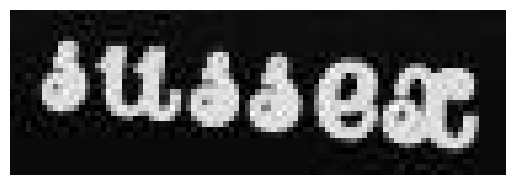

In [95]:
import matplotlib.pyplot as plt

plt.imshow(cv2.imread('D:/mnt/ramdisk/max/90kDICT32px\\./124/6/122_sussex_76563.jpg', cv2.IMREAD_GRAYSCALE), cmap='gray')  # Use cmap='gray' for grayscale images if needed
#plt.imshow(cv2.imread('D:/mnt/ramdisk/max/90kDICT32px\\./181/5/121_Temple_78079.jpg'))  # Use cmap='gray' for grayscale images if needed
plt.axis('off')  # Remove axes for better visualization
plt.show() 